In [1]:
%load_ext autoreload
%autoreload 2

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import colors

In [5]:
print(Fido)
result = Fido.search(
    a.Time("2012/6/13 07:30:00", "2012/6/13 07:31"),
    a.Instrument.hmi,
    a.Physobs("LOS_magnetic_field"),
)
result

sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`sunpy-tutorial-acquiring-data-index`.


      Client      ...
----------------- ...
CDAWEBClient      ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...


Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str18,str6,str4,str4,str8,float64
2012-06-13 07:30:41.000,2012-06-13 07:30:42.000,SDO,HMI,6173.0 .. 6174.0,JSOC,LOS_magnetic_field,NARROW,4096,4096,FULLDISK,-0.00098


In [6]:
downloaded_files = Fido.fetch(result)
downloaded_files

Files Downloaded: 100%|██████████| 1/1 [00:49<00:00, 49.86s/file]


['/Users/lilli/sunpy/data/hmi_m_45s_2012_06_13_07_31_30_tai_magnetogram.fits']

In [7]:
path = "/Users/lilli/sunpy/data/hmi_m_45s_2012_06_13_07_31_30_tai_magnetogram.fits"
hmi_image = sunpy.map.Map(path).rotate()

In [30]:
left_corner = SkyCoord(
    Tx=-492 * u.arcsec, Ty=-350 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=-208 * u.arcsec, Ty=-100 * u.arcsec, frame=hmi_image.coordinate_frame
)

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

cmap = colors.LinearSegmentedColormap.from_list("", ["black", "white"])

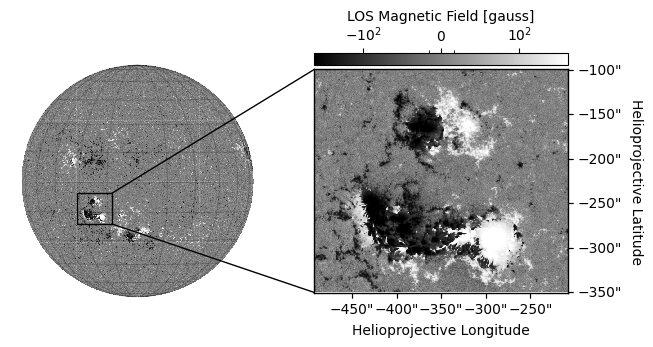

In [31]:
fig = plt.figure(figsize=(7.2, 4.8))
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="black", alpha=0.25, lw=0.5)

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=1
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")
xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=1,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=1,
)
ax2.add_artist(con1)
ax2.add_artist(con2)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = matplotlib.ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")
plotname = "/Users/lilli/Desktop/Paper/SDO_07052022.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [33]:
hdr = hmi_image.fits_header
dist = hdr["DSUN_OBS"]
pixelsize_x_unit = hdr["CUNIT1"]
pixelsize_y_unit = hdr["CUNIT2"]
pixelsize_x_arcsec = hdr["CDELT1"]
pixelsize_y_arcsec = hdr["CDELT2"]

if not pixelsize_x_unit == pixelsize_y_unit:
    print("Pixelsize units not matchy-matchy")
    raise ValueError
if not pixelsize_x_arcsec == pixelsize_y_arcsec:
    print("Data pixelsizes in x and y direction not matchy-matchy")
    raise ValueError
else:
    pixelsize_radians = pixelsize_x_arcsec / 206265.0
dist_km = dist / 1000.0
pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

In [34]:
nresol_x = magnetogram_small.data.shape[1]
nresol_y = magnetogram_small.data.shape[0]

xmax_Mm = nresol_x * pixelsize_Mm
ymax_Mm = nresol_y * pixelsize_Mm
pixelsize_z_Mm = 90.0 * 10**-3

zmax_Mm = 20000.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

xmax = xmax_Mm
ymax = ymax_Mm
zmax = zmax_Mm
z0 = z0

pixelsize_x = pixelsize_Mm
pixelsize_y = pixelsize_Mm
pixelsize_z = pixelsize_Mm
print("xmax, ymax, zmax", xmax, ymax, zmax)
print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

xmax, ymax, zmax 209.615 184.387 20.0
xmax_Mm, ymax_Mm, zmax_Mm 209.615 184.387 20.0
nresol_x, nresol_y, nresol_z 565 497 222
pixelsize_x, pixelsize_x_Mm 0.371 0.371
pixelsize_y, pixelsize_y_Mm 0.371 0.371
pixelsize_z, pixelsize_z_Mm 0.371 0.371


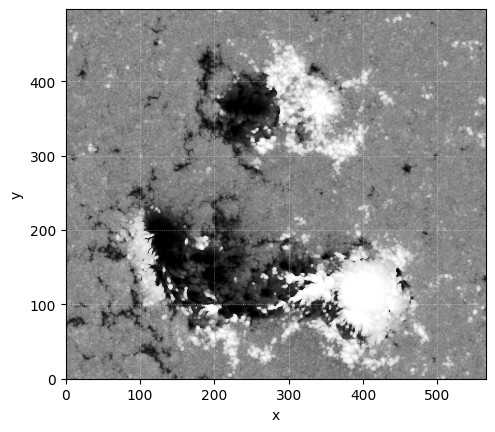

In [35]:
x_arr = np.arange(nresol_x) * (nresol_x) / (nresol_x - 1)
y_arr = np.arange(nresol_y) * (nresol_y) / (nresol_y - 1)
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

fig = plt.figure()
ax = fig.add_subplot(111)
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax.grid(color="white", alpha=0.6, linestyle="dotted", linewidth=0.5)
ax.contourf(y_plot, x_plot, magnetogram_small.data, 1000, norm=norm, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(ymax / xmax)
plt.show()

In [36]:
from mflex.classes.clsmod import DataBz

data = DataBz(
    magnetogram_small.data,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    nf_max,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    z0,
)

data_bz = data.data_z
x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

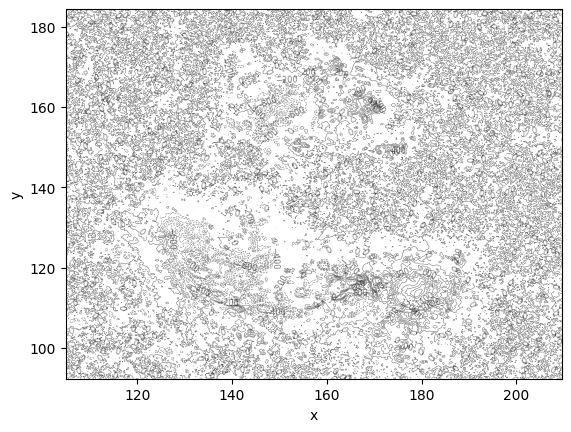

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    20,
    colors="k",
    linewidths=0.4,
    alpha=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=6, inline=True)
plt.show()

In [41]:
z0_b = z0
deltaz_b = z0 / 10.0
L = 1.0
# a = 0.2
# alpha = 0.008
b = 1.0

alpha = 0.0
a = 0.0

length_scale = float(2.0 * L)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x * L
length_scale_y = 2.0 * nresol_y * pixelsize_y * L

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.5


In [42]:
from mflex.model.field.bfield_model import magnetic_field

bfield, dpartial_bfield = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    L,
)

length scale 2.0
length scale x 419.23
length scale y 368.774
length scale x norm 209.615
length scale y norm 184.387
xmin, xmax, ymin, ymax, zmin, zmax  0.0 209.615 0.0 184.387 0.0 20.0


In [ ]:
from mflex.plot.plot_magnetogram import plot_fieldlines_sdo_paper

h1 = L / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L  # Maximum step length for fieldline3D

plot_fieldlines_sdo_paper(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=7.0,
    view="top",
    cmap=cmap,
)

plot_fieldlines_sdo_paper(
    bfield,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=7.0,
    view="side",
    cmap=cmap,
)